## Code for example 3.2 in the paper

In [1]:
from jaxpinns.base import PINN
%load_ext autoreload
%autoreload 2
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
from scipy.linalg import eigh
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc

from jax import random, grad, jit, vmap
from jax.tree_util import Partial as partial
from jax.ops import segment_sum
import jax
from jax.scipy.optimize import minimize
import numpy as onp
#from jax.experimental import optimizers

from Mesh import Mesh
import igl

import jax.numpy as np
from jax import random, grad, vmap, jvp

from jaxpinns.samplers import Sampler
from jax.example_libraries import optimizers


from jaxpinns.architectures import MLP
from jaxpinns.optimizers import adam
from jaxpinns.loggers import logger

import matplotlib.pyplot as plt

from torch.utils import data

from scipy.sparse.linalg import spsolve


onp.random.seed(1234)
rng_key = random.PRNGKey(0)

import time
import meshio

import igl

In [2]:
mvtu = meshio.read('data/convection000000.vtu')

verts = mvtu.points
connectivity = mvtu.cells_dict['triangle']

In [3]:
m = Mesh(verts = verts, connectivity = connectivity)

print('Computing Laplacian')
K, M = m.computeLaplacian()
print('Computing eigen values')
eigvals, eigvecs = eigh(K,M)

Computing Laplacian
Computing eigen values


In [4]:
Kigl = igl.cotmatrix(m.verts, m.connectivity.astype(int))
Migl = igl.massmatrix(m.verts, m.connectivity.astype(int))

numlap = Kigl.tolil()

In [5]:
class LaplacePINN(PINN):
    # Initialize the class
    def __init__(self, eigenfuncs, connectivity, mesh_operator, norm_const, mu_X = 0.0, sigma_X = 1.0):
        super().__init__(mu_X, sigma_X)

        self.eigenfuncs = np.array(eigenfuncs)
        self.connectivity = connectivity
        self.mesh_operator = mesh_operator
        self.Xc = self.eigenfuncs[self.connectivity.flatten(),:]

        self.mu_y = norm_const['mu_y']
        self.sigma_y = norm_const['sigma_y']
        self.num_loss_terms = 2

    # Make sure this accepts a single input data-point and returns a scalar!
    # Then use vmap to vectorize
    def net_u(self, params, x):
        inputs = np.stack([x])
        u = self.net_apply(params, inputs)
        return u[0][0]

    def net_r(self, params, x):
        u_v = grad(self.net_u, 1)(params, x)*self.sigma_y
        return u_v


    @partial(jit, static_argnums=(0,))
    def loss_u(self, params, batch):
        # Fetch data
        inputs, targets = batch
        X, _, _, _ = inputs
        Y, _ = targets
        # Evaluate model
        u_fn = lambda x: self.net_u(params, x)
        u_pred = vmap(u_fn)(X)
        # Compute loss
        loss_u = np.mean((Y - u_pred)**2)
        return loss_u

    @partial(jit, static_argnums=(0,))
    def loss_r(self, params, batch):
        # Fetch data
        inputs, targets = batch
        _, V_res, vals, segments = inputs # V_x (batch_size, n_eig, 3), V_xx: (batch_size, n_eig)
        _, Y_res = targets

        u_res = vmap(self.net_u, in_axes=(None,0))(params, V_res)*self.sigma_y + self.mu_y

        res = segment_sum(u_res*vals, segments, 30)

        # Compute loss
        loss_r = np.sum(res**2)/(segments[-1] + 1)
        return loss_r

    def loss(self, params, batch, weights=(1.0,1.0)):
        w_u, w_r = weights
        loss_u = self.loss_u(params, batch)
        loss_r = self.loss_r(params, batch)
        loss = w_u*loss_u + w_r*loss_r
        return loss

    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict(self, params, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        u_fn = lambda x: self.net_u(params, x)
        u_star = vmap(u_fn)(X_star)
        return u_star

 

class LaplacePINNGenerator(data.Dataset):
    def __init__(self, V, Y, Vc, numlap, idx_c,
                 batch_size=1, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.V = V
        self.Y = Y
        self.Vc = Vc #all the eigenfunctions 
        self.numlap = numlap #numerical laplacian
        self.idx_c = idx_c # list of all the collocation nodes
        self.key = rng_key
        self.batch_size = batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(subkey)
        return inputs, targets

 #   @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.V.shape[0], (self.batch_size,), replace = False)
        idx_e = random.choice(key, self.idx_c, (self.batch_size,), replace = False)

        nodes = []
        vals = []
        segments = []
        # this is needed to perform sparse matrix multiplication in JAX with the function segment_sum
        for i, a in enumerate(idx_e):
            nodes += self.numlap.rows[a]
            vals += self.numlap.data[a]
            segments += [i]*len(self.numlap.rows[a])

        # Make inputs, outputs
        inputs  = (self.V[idx], self.Vc[nodes], np.array(vals), np.array(segments))
        outputs = (self.Y[idx], np.zeros((self.batch_size,1)))
        return inputs, outputs

In [6]:
n_nodes = m.verts.shape[0]
N = n_nodes
rng_key, subkey = random.split(rng_key)
idx_train = random.choice(random.PRNGKey(30), n_nodes, (N,), replace = False)


In [8]:
# retrieve the boundary points

data_int = np.load('data/heat_interp_data.npz')

boundary_points = data_int['points']
sfun = data_int['sfun']

from scipy.spatial import cKDTree

tree = cKDTree(m.verts[:,:2])

_, idx_boundary = tree.query(boundary_points)

boundary_mask = onp.ones(n_nodes).astype(bool)

boundary_mask[idx_boundary] = False

In [9]:
n_eigs = 50

eigpairs = (np.array(eigvals[:n_eigs]), np.array(eigvecs[:,:n_eigs]).T)
eigfuncs = eigvecs[:,:n_eigs]

n_nodes = eigpairs[1].shape[1]
coords = m.verts

Y_true = np.array(mvtu.point_data['f_937'])



idx_c = np.where(boundary_mask)[0]

Y = Y_true[~boundary_mask]

V = eigfuncs[~boundary_mask]


sigma_y = Y.std()
mu_y = Y.mean()
Y = (Y - mu_y)/sigma_y

norm_const = {'mu_y': mu_y, 'sigma_y': sigma_y}

Bs = []

for e in range(m.connectivity.shape[0]):
    B, J = m.Bmatrix(e)
    Bs.append(np.dot(B.T, B)/J**2)

Bs = np.array(Bs)




In [10]:
dataset = LaplacePINNGenerator(np.array(V), np.array(Y), eigfuncs, numlap, idx_c, batch_size=30)

In [11]:
model = LaplacePINN(eigfuncs, m.connectivity, Bs, norm_const)


In [12]:
# Setup architecture
init_key = random.PRNGKey(0)
layers = [n_eigs, 100,100,100, 1]
args = (layers,)
model.architecture(MLP, *args, init_key=init_key)

In [13]:
# Setup optimizer
saved_state = None
learning_rate = optimizers.exponential_decay(1e-3, decay_steps=100, decay_rate=0.99)
args = (learning_rate, model.loss)
model.optimizer(adam, *args, saved_state=saved_state)

In [14]:
# Setup logger
io_keys = ['loss','loss_u','loss_r']
log_keys = ['loss','loss_u','loss_r']
log_funs = [model.loss, model.loss_u, model.loss_r]
args = (io_keys, log_keys, log_funs)
model.logger(logger, *args, io_step = 200)

In [15]:
# Train
#validation_data = (X_star, u_star)
model.train(dataset, nIter = 50000, ntk_weights = False)

100%|██████████| 50000/50000 [04:33<00:00, 182.57it/s, loss=4.922290199410376e-06, loss_u=1.6814337083141628e-06, loss_r=3.2408564910962128e-06] 


0.001133006699631023


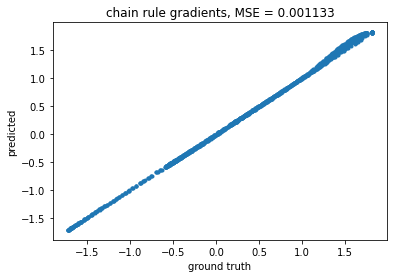

In [16]:
opt_params = model.get_params(model.opt_state)
u_pred = model.predict(opt_params, eigfuncs)

MSE = np.mean(((Y_true - mu_y)/sigma_y - u_pred)**2)
plt.plot((Y_true - mu_y)/sigma_y , u_pred,'.')
#plt.scatter(Y , Y, c = 'r', zorder = 100, label = 'data')
plt.xlabel('ground truth')
plt.ylabel('predicted')
plt.title('chain rule gradients, MSE = %f' % MSE )
print(MSE)
#plt.savefig('../output/coil_1.2_MM_chainrulegrad.png')

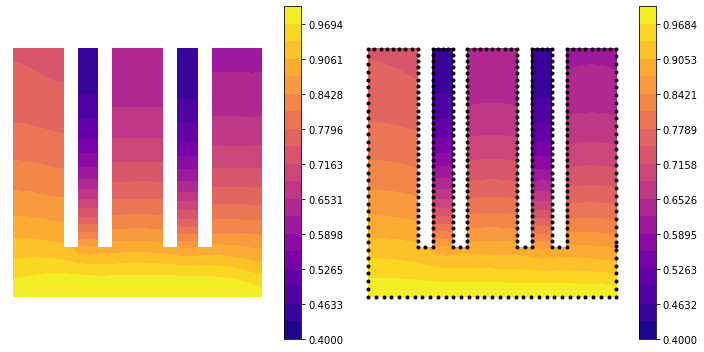

In [17]:
fig = plt.figure()
fig.set_size_inches((10,5))

plt.subplot(121)
plt.tricontourf(verts[:,0], verts[:,1], connectivity, u_pred*sigma_y + mu_y,  np.linspace(0.4,1.001,20), cmap = plt.cm.plasma)
plt.colorbar()
#plt.scatter(verts[idx_train,0], verts[idx_train,1])
plt.axis('equal')
plt.axis('off')

plt.subplot(122)
plt.tricontourf(verts[:,0], verts[:,1], connectivity, Y_true, np.linspace(0.4,1,20), cmap = plt.cm.plasma)
plt.colorbar()

plt.plot(verts[~boundary_mask,0], verts[~boundary_mask,1],'k.')
plt.axis('equal')
plt.axis('off')


plt.tight_layout()

#plt.savefig('../output/LaplacePINNs_numheat.pdf')